In [1]:
# basic imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# sklearn
# preprocessing, model selection and metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# visualize importances
import shap

pd.set_option('max_columns', None)
plt.style.use('ggplot')

In [2]:
from datetime import date
import gc

In [3]:
my_data = './data/'
fat_ljs_atual = pd.read_csv(my_data + 'faturamento_lojas_atuais.csv')
cen_exp = pd.read_csv(my_data + 'cenarios_expansao.csv')
ljs_atual = pd.read_csv(my_data + 'lojas_atuais.csv')

In [4]:
merge = fat_ljs_atual.merge(ljs_atual, on='cod_loja')

In [5]:
merge

,cod_loja,ano,mes,categoria,qtde,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
0,1,2016,1,CATEG_01,301.0,9164.86,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,2,CATEG_01,187.0,8175.55,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2016,3,CATEG_01,242.0,10521.67,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2016,4,CATEG_01,104.0,4560.91,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2016,5,CATEG_01,100.0,4263.30,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003089,3687,2017,8,CATEG_14,334.0,634.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003090,3687,2017,9,CATEG_14,33.0,62.70,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003091,3687,2017,10,CATEG_14,184.0,349.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003092,3687,2017,11,CATEG_14,28.0,61.30,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
mun_list = cen_exp.cod_municipio.unique()

In [7]:
###### cen_exp.head()
mun = mun_list[57]

fat_mun = merge[merge.cod_municipio == mun]
feats = ['feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']
group16 = fat_mun[fat_mun.ano == 2016].groupby(['cod_loja', 'cod_municipio', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
group17 = fat_mun[fat_mun.ano == 2017].groupby(['cod_loja', 'cod_municipio', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
mensal = group16.append(group17)
mensal['datetime'] = pd.to_datetime(mensal.ano*100+mensal.mes,format='%Y%m')
mensal

,cod_loja,cod_municipio,mes,ano,cod_ap,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,qtde,receita,datetime


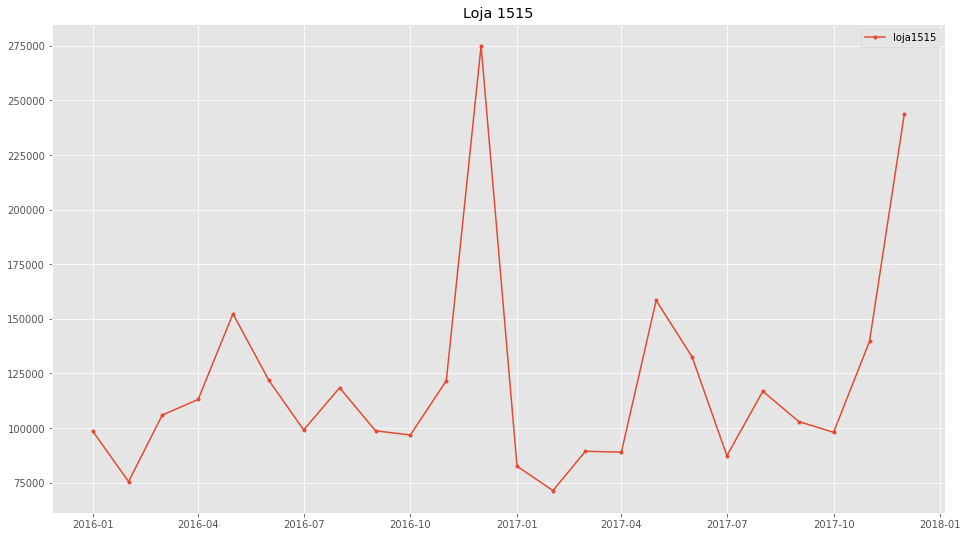

In [124]:
plt.figure(figsize=(16,9))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.title("Loja {}".format(cod))
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

In [9]:
cen_exp[cen_exp.cod_loja == 28]

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
4,28,3550308005058,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,True,44.31,FEATURE_05_VALUE_03,8,0.190102,0.17914,5593.905463,2.815883,FEATURE_11_VALUE_02,FEATURE_12_VALUE_01,NaN,NaN,NaN,NaN,NaN,NaN


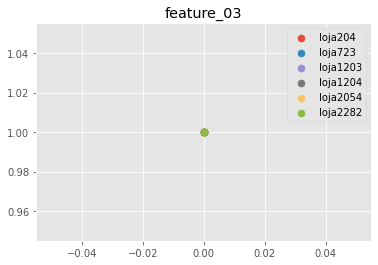

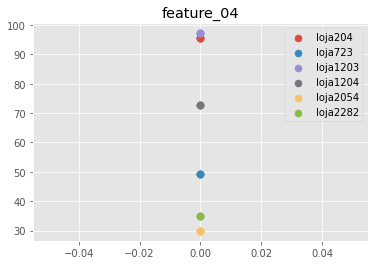

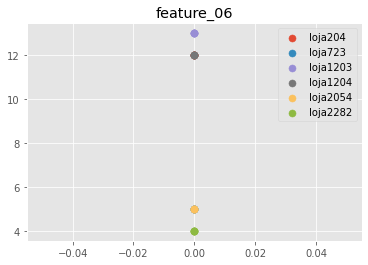

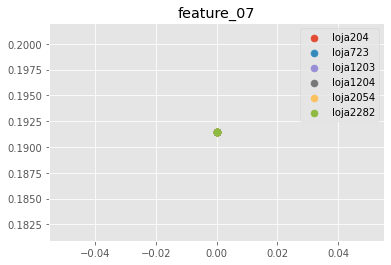

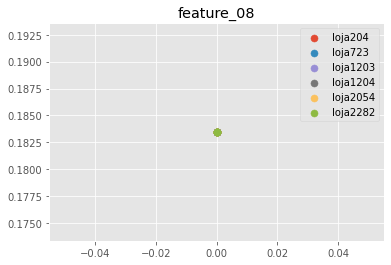

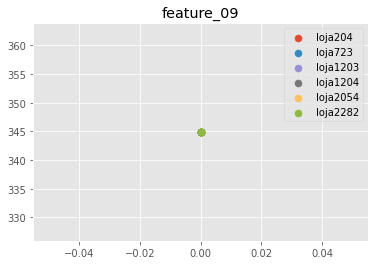

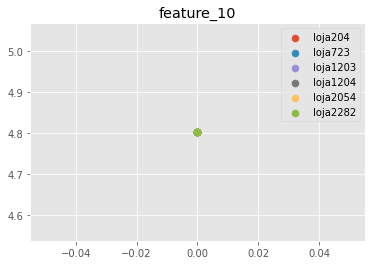

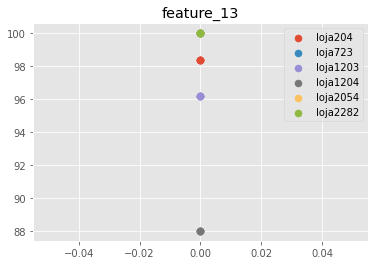

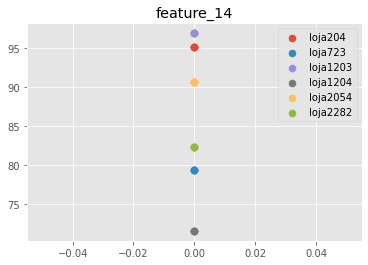

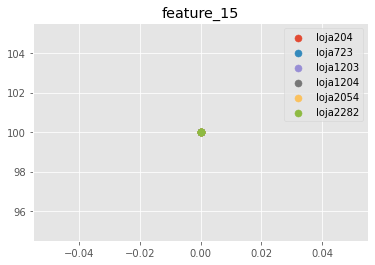

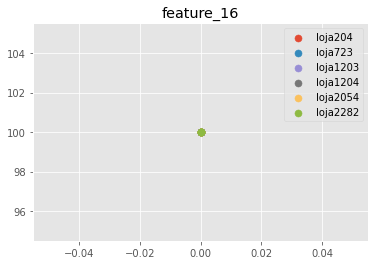

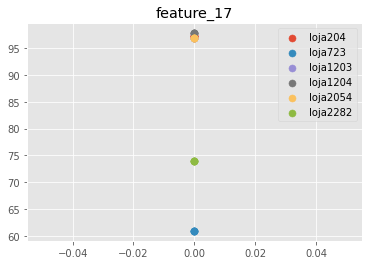

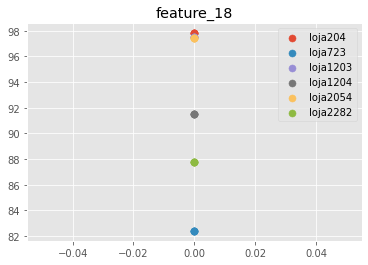

In [88]:
lojas_feats = mensal.groupby(['cod_loja'] + feats, as_index=False).sum()[['cod_loja'] + feats]
for feat in feats:
    for cod in mensal.cod_loja.unique()[:]:
        loj_mensal = mensal[mensal.cod_loja == cod]
        plt.scatter([0,0,0,0,0], loj_mensal[feat][:5], label='loja' + str(cod), marker=".", s=200, vmin=-1, vmax=1)
        plt.legend()
    plt.title(feat)
    plt.show()


In [32]:
feats[8:10]

['feature_14', 'feature_15']

In [35]:
ljs_atual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cod_loja       3130 non-null   int64  
 1   cod_ap         3130 non-null   int64  
 2   cod_municipio  3130 non-null   int64  
 3   feature_01     1171 non-null   object 
 4   feature_02     3130 non-null   object 
 5   feature_03     3130 non-null   bool   
 6   feature_04     3130 non-null   float64
 7   feature_05     3130 non-null   object 
 8   feature_06     3130 non-null   int64  
 9   feature_07     3130 non-null   float64
 10  feature_08     3130 non-null   float64
 11  feature_09     3130 non-null   float64
 12  feature_10     3130 non-null   float64
 13  feature_11     245 non-null    object 
 14  feature_12     245 non-null    object 
 15  feature_13     874 non-null    float64
 16  feature_14     874 non-null    float64
 17  feature_15     874 non-null    float64
 18  feature_

## Tentativa por mesorregião

In [5]:
ibge = pd.read_excel(my_data + 'ibge.xls')

In [6]:
ibge.head()
mun_meso = ibge[['Mesorregião Geográfica', 'UF', 'Código Município Completo']]
mun_meso.rename(columns={'Mesorregião Geográfica': 'meso', 'Código Município Completo': 'cod_municipio'}, inplace=True)

mun_meso['uf_meso'] = (mun_meso.UF.astype(str) + mun_meso.meso.astype(str)).astype(int)
mun_meso.drop(columns=['meso', 'UF'], inplace=True)

me_merge = merge.merge(mun_meso, on='cod_municipio', how='left')
me_merge_cex = cen_exp.merge(mun_meso, on='cod_municipio', how='left')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
mesos = me_merge_cex.uf_meso.unique()
idx = 79

fat_mun = me_merge[me_merge.uf_meso == mesos[idx]]
feats = ['feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']
group16 = fat_mun[fat_mun.ano == 2016].groupby(['cod_loja', 'cod_municipio', 'uf_meso', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
group17 = fat_mun[fat_mun.ano == 2017].groupby(['cod_loja', 'cod_municipio', 'uf_meso', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
mensal = group16.append(group17)
mensal['datetime'] = pd.to_datetime(mensal.ano*100+mensal.mes,format='%Y%m')

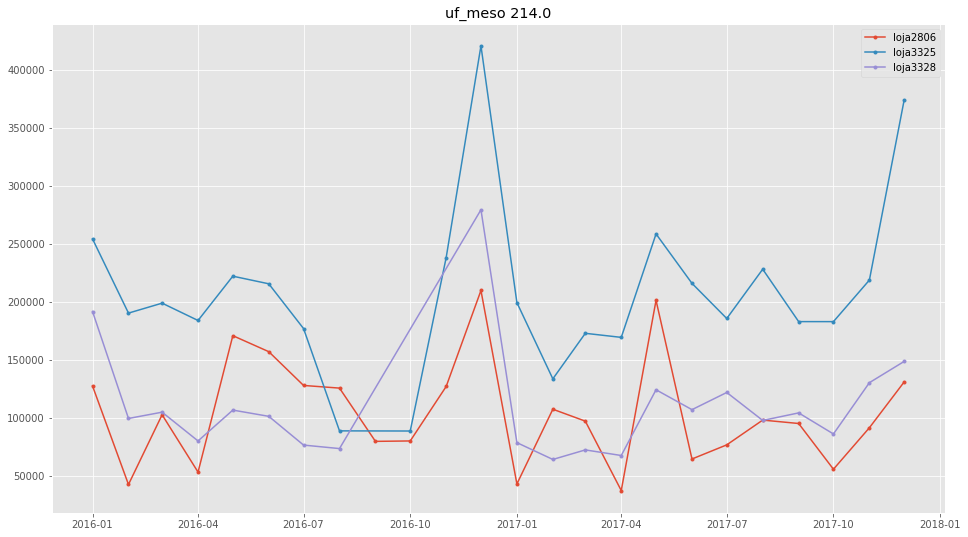

In [8]:
plt.figure(figsize=(16,9))
plt.title("uf_meso {}".format(mesos[idx]))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

In [44]:
mensal

,cod_loja,cod_municipio,uf_meso,mes,ano,cod_ap,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,qtde,receita,datetime
0,2806,2103307,214.0,1,2016,2103307003003,False,46.5,4,0.122904,0.115997,25.915630,1.662994,100.0,45.0,0.0,100.0,50.6,69.5,2915.0,127205.00,2016-01-01
1,2806,2103307,214.0,2,2016,2103307003003,False,46.5,4,0.122904,0.115997,25.915630,1.662994,100.0,45.0,0.0,100.0,50.6,69.5,868.0,42248.58,2016-02-01
2,2806,2103307,214.0,3,2016,2103307003003,False,46.5,4,0.122904,0.115997,25.915630,1.662994,100.0,45.0,0.0,100.0,50.6,69.5,1841.0,102392.97,2016-03-01
3,2806,2103307,214.0,4,2016,2103307003003,False,46.5,4,0.122904,0.115997,25.915630,1.662994,100.0,45.0,0.0,100.0,50.6,69.5,1029.0,52943.89,2016-04-01
4,2806,2103307,214.0,5,2016,2103307003003,False,46.5,4,0.122904,0.115997,25.915630,1.662994,100.0,45.0,0.0,100.0,50.6,69.5,2821.0,170634.14,2016-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,3328,2103505,214.0,8,2017,2103505003001,False,52.5,3,0.082068,0.079326,8.446996,4.966723,96.2,82.5,0.0,100.0,95.4,91.4,1952.0,97515.63,2017-08-01
32,3328,2103505,214.0,9,2017,2103505003001,False,52.5,3,0.082068,0.079326,8.446996,4.966723,96.2,82.5,0.0,100.0,95.4,91.4,2002.0,104009.14,2017-09-01
33,3328,2103505,214.0,10,2017,2103505003001,False,52.5,3,0.082068,0.079326,8.446996,4.966723,96.2,82.5,0.0,100.0,95.4,91.4,1858.0,85841.15,2017-10-01
34,3328,2103505,214.0,11,2017,2103505003001,False,52.5,3,0.082068,0.079326,8.446996,4.966723,96.2,82.5,0.0,100.0,95.4,91.4,2506.0,130073.87,2017-11-01


In [11]:
mun_meso

,cod_municipio,uf_meso
0,1100015,112
1,1100379,112
2,1100403,112
3,1100346,112
4,1100023,112
...,...,...
5565,5222005,525
5566,5222054,525
5567,5222203,524
5568,5222302,524


## Mesorregiões do cen_exp não encontradas nas lojas atuais

In [8]:
print("TOTAL SIZE: " + str(len(mesos)))
mmesos = []
cnt = 0
for meso in mesos:
    fm = me_merge[me_merge.uf_meso == meso]
    if fm.index.size == 0:
        mmesos.append(meso)
        cnt += 1
        
print("\n" + str(cnt) + " " + str(cnt/len(mesos)))

TOTAL SIZE: 114

2 0.017543859649122806


## Microrregiões

In [9]:
ibge.head()
mun_micro = ibge[['Microrregião Geográfica', 'UF', 'Código Município Completo']]
mun_micro.rename(columns={'Microrregião Geográfica': 'micro', 'Código Município Completo': 'cod_municipio'}, inplace=True)

mun_micro['uf_micro'] = (mun_micro.UF.astype(str) + mun_micro.micro.astype(str)).astype(int)
mun_micro.drop(columns=['micro', 'UF'], inplace=True)

mi_merge = merge.merge(mun_micro, on='cod_municipio', how='left')
mi_merge_cex = cen_exp.merge(mun_micro, on='cod_municipio', how='left')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
aa = mun_micro[mun_micro.uf_micro == 2929].cod_municipio.values.tolist()
ljs_atual[ljs_atual.cod_municipio.isin(aa)]

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
831,965,2915809001001,2915809,NaN,FEATURE_02_VALUE_04,True,20.87,FEATURE_05_VALUE_03,2,0.116662,0.114995,6.713182,4.286878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2471,2913,2916807001001,2916807,NaN,FEATURE_02_VALUE_04,False,25.48,FEATURE_05_VALUE_03,2,0.116662,0.114995,5.660488,14.932059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
mi_merge[mi_merge.uf_micro == 2929].groupby(['cod_loja', 'mes', 'ano'], as_index=False).sum()

,cod_loja,mes,ano,qtde,receita,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,uf_micro
0,965,1,2016,721.0,26111.75,37905517013013,37905517,13,271.31,26,1.516606,1.494936,87.271362,55.729412,0.0,0.0,0.0,0.0,0.0,0.0,38077.0
1,965,1,2017,344.0,16187.60,37905517013013,37905517,13,271.31,26,1.516606,1.494936,87.271362,55.729412,0.0,0.0,0.0,0.0,0.0,0.0,38077.0
2,965,2,2016,412.0,15828.27,37905517013013,37905517,13,271.31,26,1.516606,1.494936,87.271362,55.729412,0.0,0.0,0.0,0.0,0.0,0.0,38077.0
3,965,2,2017,427.0,17199.05,37905517013013,37905517,13,271.31,26,1.516606,1.494936,87.271362,55.729412,0.0,0.0,0.0,0.0,0.0,0.0,38077.0
4,965,3,2016,361.0,16249.33,34989708012012,34989708,12,250.44,24,1.399944,1.379941,80.558180,51.442534,0.0,0.0,0.0,0.0,0.0,0.0,35148.0
5,965,3,2017,488.0,18094.79,34989708012012,34989708,12,250.44,24,1.399944,1.379941,80.558180,51.442534,0.0,0.0,0.0,0.0,0.0,0.0,35148.0
6,965,4,2016,443.0,21059.56,34989708012012,34989708,12,250.44,24,1.399944,1.379941,80.558180,51.442534,0.0,0.0,0.0,0.0,0.0,0.0,35148.0
7,965,4,2017,409.0,18640.17,40821326014014,40821326,14,292.18,28,1.633268,1.609932,93.984544,60.016290,0.0,0.0,0.0,0.0,0.0,0.0,41006.0
8,965,5,2016,532.0,23727.19,37905517013013,37905517,13,271.31,26,1.516606,1.494936,87.271362,55.729412,0.0,0.0,0.0,0.0,0.0,0.0,38077.0
9,965,5,2017,598.0,30715.25,37905517013013,37905517,13,271.31,26,1.516606,1.494936,87.271362,55.729412,0.0,0.0,0.0,0.0,0.0,0.0,38077.0


In [13]:
lojas_sem_micro = mi_merge_cex.uf_micro.isin(mmicros)
lojas_sem_micro.value_counts()
#rel_me_merge = me_merge[me_merge['cod_loja'].isin(lojas_sem_micro.values.tolist())]
#rec_med_meso = rel_me_merge.groupby(['mes', 'uf_meso'], as_index=False).mean()
#rec_med_meso

NameError: name 'mmicros' is not defined

In [62]:
rec_med_mensal = mi_merge.groupby(['mes', 'uf_micro'], as_index=False).mean()[['uf_micro', 'mes', 'receita']]
mi_merge_cex = mi_merge_cex.merge(rec_med_mensal, on='uf_micro')

In [101]:
mi_merge[mi_merge.uf_micro.isna()].groupby('cod_loja', as_index=False).mean()
lojas_sem_micro = mi_merge[mi_merge.uf_micro.isna()].groupby('cod_loja', as_index=False).mean()['cod_loja']

In [147]:
mi_merge_cex.uf_micro.unique()

array([2928., 2929., 2920.,  298., 3561., 3548., 3518., 3512., 2110.,
       2324., 3118., 3156., 3153., 3142., 5212., 5217.,  176.,  426.,
       4139., 4111.,  415., 3130., 4122.,  329., 3164., 3514.,  316.,
        355., 3539.,  513., 4326.,  241., 2411., 2925., 3315., 4125.,
        437., 3532., 3149.,  174., 4212.,  296.,  219., 2412.,  527.,
        226., 1510., 3313., 3123.,  279.,  265., 3212., 2911., 4121.,
       3547., 5210., 4137., 3162., 4134., 2922., 2616.,  268., 1517.,
       5113., 2712., 3318., 3127., 4324., 5214., 3546., 5114., 3150.,
       3151., 4325., 4124.,  313.,  295., 3165., 3515., 2326.,  505.,
       3117., 3131.,  526., 3143., 3560.,  218.,  336., 2932., 4219.,
       3526., 4316., 2916., 5117., 3563.,  424., 3555., 2418., 2416.,
       3558.,  178., 2914.,  273., 2617., 4321., 4310., 3562., 3133.,
       2613., 3559., 1513., 3519., 2811., 3522., 4213., 4216., 3124.,
        322.,  325., 3154., 2610., 5111., 3310.,  215.,  419., 5215.,
       3119.,  216.,

In [91]:
mi_merge_cex[['cod_loja', 'mes', 'receita']].to_csv(my_data + "media_receitas_microrregiao.csv", index=False)

## Microrregiões do cen_exp não encontradas nas lojas atuais

In [74]:
micros = mi_merge_cex.uf_micro.unique()
print("TOTAL SIZE: " + str(len(micros)))
mmicros = []
cnt = 0
for micro in micros:
    fm = mi_merge[mi_merge.uf_micro == micro]
    if fm.index.size == 0:
        mmicros.append(micro)
        cnt += 1
        
print("\n" + str(cnt) + " " + str(cnt/len(micros)))

TOTAL SIZE: 236

13 0.05508474576271186


In [75]:
mmicros

[3135.0,
 433.0,
 4211.0,
 225.0,
 nan,
 4334.0,
 121.0,
 2114.0,
 4132.0,
 4128.0,
 2514.0,
 2311.0,
 2330.0]

In [177]:
mi_merge[mi_merge.cod_loja.isin([341, 784, 1956, 2453])].groupby('cod_loja').mean()

,ano,mes,qtde,receita,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,uf_micro
cod_loja,,,,,,,,,,,,,,,,,,,,
341,2016.50000,6.514970,99.763473,5342.925958,5.106422e+12,5106422.0,False,25.00,3.0,0.281184,0.264856,8.259914,3.047108,NaN,NaN,NaN,NaN,NaN,NaN,513.0
784,2016.50000,6.536364,124.600000,6237.035667,5.104104e+12,5104104.0,False,24.00,3.0,0.281184,0.264856,11.535855,2.947331,NaN,NaN,NaN,NaN,NaN,NaN,513.0
1956,2016.49848,6.513678,108.863222,5584.164802,2.402006e+12,2402006.0,False,25.42,6.0,0.164473,0.134588,28.434102,2.973580,NaN,NaN,NaN,NaN,NaN,NaN,2411.0
2453,2016.50000,6.509202,49.199387,2629.972485,2.405603e+12,2405603.0,False,28.39,4.0,0.164473,0.134588,4.856225,6.846501,NaN,NaN,NaN,NaN,NaN,NaN,2411.0


In [173]:
micros = mi_merge_cex.uf_micro.unique()
idx = 32

fat_mun = mi_merge[mi_merge.uf_micro == micros[idx]]
group16 = fat_mun[fat_mun.ano == 2016].groupby(['cod_loja', 'mes', 'ano'], as_index=False).sum()
group17 = fat_mun[fat_mun.ano == 2017].groupby(['cod_loja', 'mes', 'ano'], as_index=False).sum()
mensal = group16.append(group17)
mensal['datetime'] = pd.to_datetime(mensal.ano*100+mensal.mes,format='%Y%m')

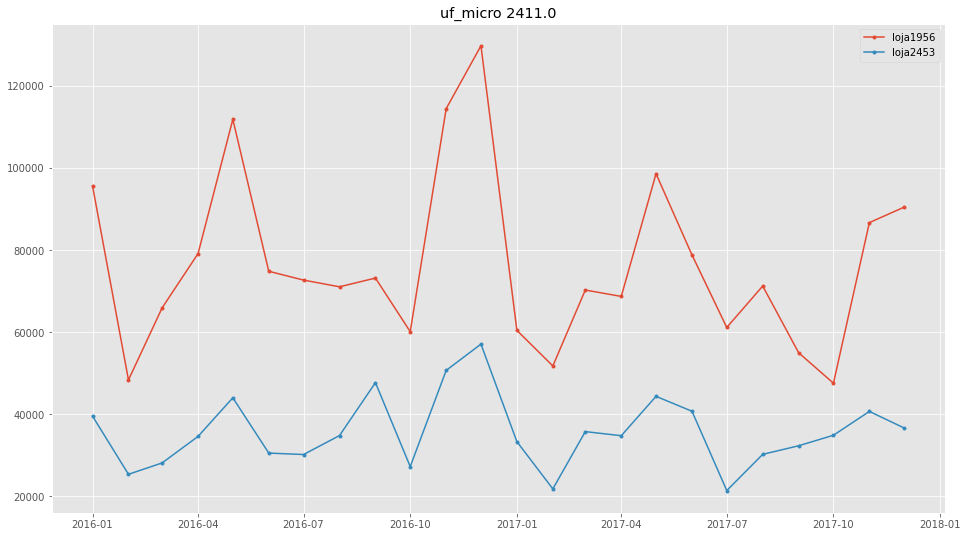

In [174]:
plt.figure(figsize=(16,9))
plt.title("uf_micro {}".format(micros[idx]))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

In [12]:
mi_merge_cex.cod_loja.unique().size

553

,cod_loja,ano,mes,categoria,qtde,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
0,1,2016,1,CATEG_01,301.0,9164.86,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,2,CATEG_01,187.0,8175.55,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2016,3,CATEG_01,242.0,10521.67,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2016,4,CATEG_01,104.0,4560.91,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2016,5,CATEG_01,100.0,4263.30,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003089,3687,2017,8,CATEG_14,334.0,634.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003090,3687,2017,9,CATEG_14,33.0,62.70,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003091,3687,2017,10,CATEG_14,184.0,349.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003092,3687,2017,11,CATEG_14,28.0,61.30,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
rmm_cidade = merge.groupby(['mes', 'ano', 'cod_municipio'], as_index=False).mean()[['mes', 'ano', 'receita', 'cod_municipio']]
rmm_cidexp = cen_exp.merge(rmm_cidade, on='cod_municipio')
cid_final = rmm_cidexp[['cod_loja', 'mes', 'ano', 'receita']]

In [153]:
cid_final.cod_loja.unique().size

354

In [154]:
munics_cex = cen_exp.cod_municipio.unique().tolist()
munics_atual = ljs_atual.cod_municipio.unique().tolist()
munics_sem_intersec = [x for x in munics_cex if x not in munics_atual]
lojas_sem_intersec = cen_exp[cen_exp.cod_municipio.isin(munics_sem_intersec)].cod_loja.values.tolist()

In [155]:
rmm_atual = mi_merge.groupby(['mes', 'ano', 'uf_micro'], as_index=False).mean()[['uf_micro', 'mes', 'ano', 'receita']]
rmm_exp = mi_merge_cex.merge(rmm_atual, on='uf_micro')
micro_final = rmm_exp[rmm_exp.cod_loja.isin(lojas_sem_intersec)][['cod_loja', 'mes', 'ano', 'receita']]

In [156]:
micro_final.cod_loja.unique().size

185

In [157]:
micros_cex = mi_merge_cex.uf_micro.unique().tolist()
micros_atual = mi_merge.uf_micro.unique().tolist()
micros_sem_intersec = [x for x in micros_cex if x not in micros_atual]

lojas_sem_micro = mi_merge_cex[mi_merge_cex.uf_micro.isin(micros_sem_intersec)]
lojas_sem_micro = lojas_sem_micro.cod_loja.values.tolist()

In [158]:
rmm_me_atual = me_merge.groupby(['mes', 'ano', 'uf_meso'], as_index=False).mean()[['uf_meso', 'mes', 'ano', 'receita']]
rmm_me_exp = me_merge_cex.merge(rmm_me_atual, on='uf_meso')
meso_final = rmm_me_exp[rmm_me_exp.cod_loja.isin(lojas_sem_micro)][['cod_loja', 'mes', 'ano', 'receita']]

In [159]:
meso_final.cod_loja.unique().size

13

In [160]:
loja_do_acre = 1314
cids_do_acre = ibge[ibge.UF == 12][['UF', 'Código Município Completo']]
acre_merge = merge.merge(cids_do_acre, left_on='cod_municipio', right_on='Código Município Completo')
rm_acre = acre_merge.groupby(['mes', 'ano'], as_index=False).mean()[['mes', 'ano', 'receita']]
rm_acre['cod_loja'] = 1314
rm_acre

,mes,ano,receita,cod_loja
0,1,2016,10999.715138,1314
1,1,2017,9782.962233,1314
2,2,2016,6973.830364,1314
3,2,2017,8140.964673,1314
4,3,2016,8037.294352,1314
5,3,2017,8283.570093,1314
6,4,2016,8946.744206,1314
7,4,2017,9520.126542,1314
8,5,2016,13545.137981,1314
9,5,2017,13611.417570,1314


In [161]:
final = cid_final.append(micro_final)
final = final.append(meso_final)
final = final.append(rm_acre)

In [162]:
final.cod_loja.unique().size

553

In [163]:
media_geral = merge.groupby(['mes', 'ano'], as_index=False).mean()[['mes', 'ano', 'receita']]
media_geral.sort_values(by=['ano', 'mes'], inplace=True)
media_geral

,mes,ano,receita
0,1,2016,8728.372818
2,2,2016,6178.108170
4,3,2016,7444.652443
6,4,2016,7660.955133
8,5,2016,10976.737980
10,6,2016,9157.342239
12,7,2016,7627.861625
14,8,2016,9142.298693
16,9,2016,7587.456969
18,10,2016,8263.264590


In [164]:
lojas_munic_na = cen_exp[cen_exp.cod_municipio == -1][['cod_loja']]

In [165]:
media_geral_m = pd.DataFrame(np.repeat(media_geral.values,lojas_munic_na.index.size,axis=0))
media_geral_m.columns = media_geral.columns

In [166]:
media_geral_m.mes = media_geral_m.mes.astype(int)
media_geral_m.ano = media_geral_m.ano.astype(int)

In [175]:
lojas_munic_na_mult = pd.DataFrame(lojas_munic_na.cod_loja.values.tolist() * 24, columns=['cod_loja'])
lojas_munic_na_mult

,cod_loja
0,771
1,875
2,1069
3,1164
4,1279
...,...
715,3353
716,3436
717,3484
718,3626


In [176]:
media_geral_m['cod_loja'] = lojas_munic_na_mult

In [177]:
media_geral_m

,mes,ano,receita,cod_loja
0,1,2016,8728.372818,771
1,1,2016,8728.372818,875
2,1,2016,8728.372818,1069
3,1,2016,8728.372818,1164
4,1,2016,8728.372818,1279
...,...,...,...,...
715,12,2017,18499.087986,3353
716,12,2017,18499.087986,3436
717,12,2017,18499.087986,3484
718,12,2017,18499.087986,3626


In [178]:
final = final.append(media_geral_m)

In [179]:
final

,cod_loja,mes,ano,receita
0,10,1,2016,6851.975507
1,10,1,2017,5858.744198
2,10,2,2016,4808.792464
3,10,2,2017,5003.799853
4,10,3,2016,5455.608116
...,...,...,...,...
715,3353,12,2017,18499.087986
716,3436,12,2017,18499.087986
717,3484,12,2017,18499.087986
718,3626,12,2017,18499.087986


In [142]:
len(final.cod_loja.unique().tolist())

553

In [144]:
final.to_csv(my_data + "receitas_cen_exp_imputadas.csv", index=False)

496